# Functions used for Data Acquisition 

This set of functions was created to generate the dataset needed to train a ML model to detect and identify the signs of the ASL alphabet. I used an object detection library called Mediapipe, and then created a function to save the samples into csv.

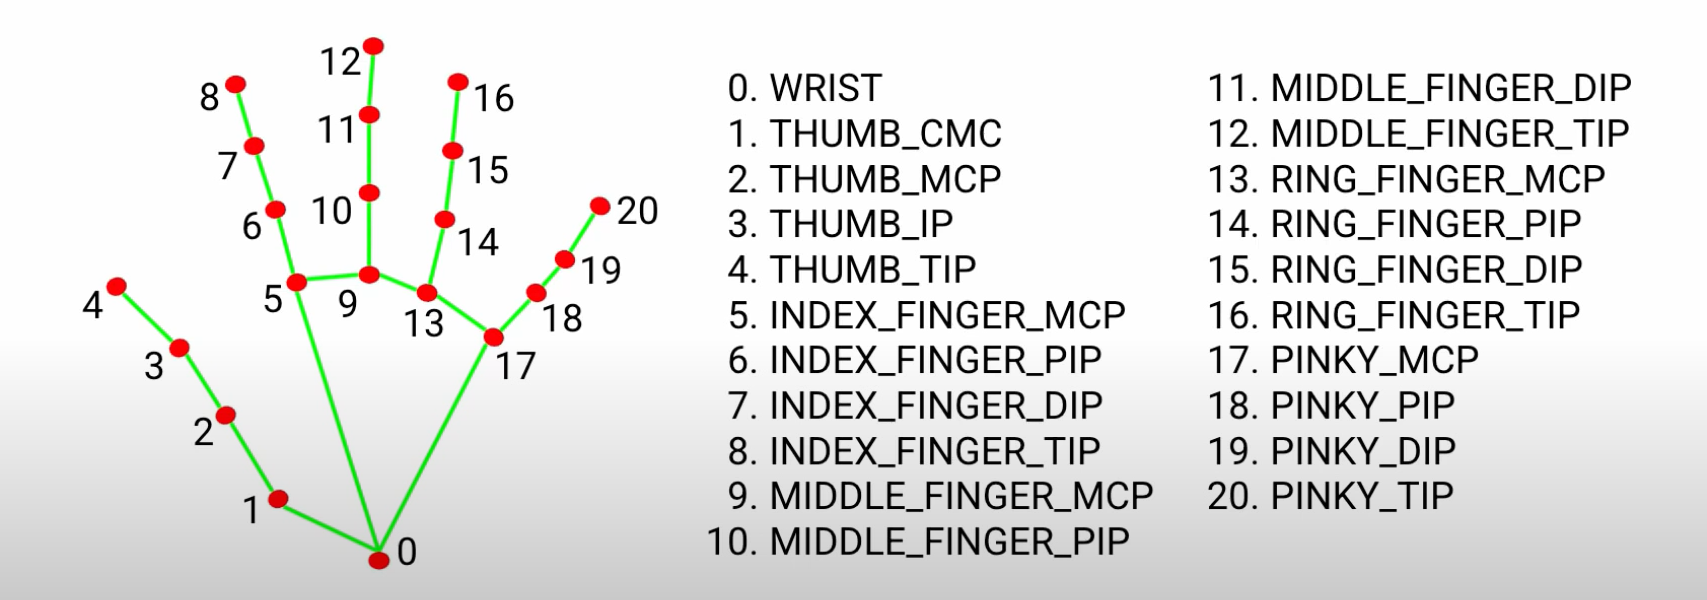

As we can see, Mediapipe hands detection module identifies 21 landmarks inside the hand. Each of those,  have 2 coordinates, a vertical and a horizontal one. Then, every raw sample will have 42 features, 21x2. We will later see how to preprocess the raw data and the feature engineering that needs to be done to maximize the prediction value of the data.

In [1]:
import mediapipe as mp
import cv2
import time
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
import os
import nbconvert

## Hand Detector:

The Hand Detector object is created using the Mediapipe library
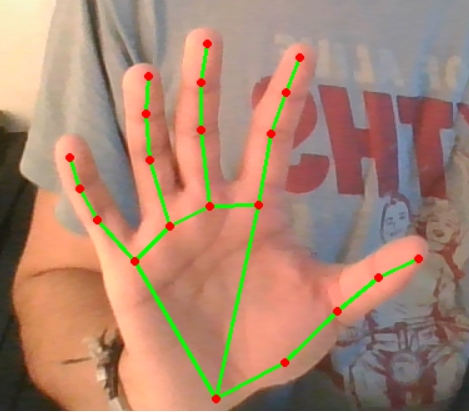  
It will detect the hand in every frame, draw the landmarks, and return the coordinates of the landmarks.

In [2]:
class hand_detector():
    def __init__(self, static=False, n_maxhands=1, detectionCon=0.5, trackingCon=0.5):
        self.mode = static
        self.n_maxhands = n_maxhands
        self.detectkionCon = detectionCon
        self.trackingCon = trackingCon
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode, self.n_maxhands, self.detectkionCon, self.trackingCon)
        self.mpDraw = mp.solutions.drawing_utils
        
    def find_hands(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        self.results = self.hands.process(imgRGB) #The model processes the img, results has all the information, ALL. 
        #print(self.results.multi_hand_landmarks) #multi hand landmarks have the coordenates of all the nodes that define a hand for the model. 
        if self.results.multi_hand_landmarks and draw:
            for handLms in self.results.multi_hand_landmarks: #for each hand
                self.mpDraw.draw_landmarks(img, handLms, self.mpHands.HAND_CONNECTIONS) #this is a single hand. We dont want it to write it in the RGB image, bc the img that we are 
                #displaying is img not imgRGB
                ##now we want to draw the line that  connects all those dots for each hand

        return img
    def find_postion(self, img, handNo=0, draw=True ):
        if self.results.multi_hand_landmarks:
            hand = self.results.multi_hand_landmarks[handNo]
            lmList = []
            h, w, c = img.shape #height, width and channels of img
            for id_,lm in enumerate(hand.landmark):
                #the coordenates are scaled, [0,1] not in pixels, to transform to pixels
                cx, cy = int(lm.x*w), int(lm.y*h)
                lmList.append([id_, cx, cy])
                #if id_ == 0:
                #cv2.circle(img, (cx, cy), 15,(255,0,255), cv2.FILLED )
            return lmList
        else: return 'None'

## Dataset Generator Function: 

I am going to save every sample in a DataFrame, that we will convert to a csv and save locally. All the samples will first be retained in a numpy array (2D, a matrix). Each iteration/frame in the loop will get us a sample (list of coordinates) that will be saved in the numpy matrix. To update the matrix I have created this function.

In [3]:
def update_sample_matrix(sample:list, sample_matrix, idx):
    row = []
    
    for coords in sample:
        #print(coords)
        row.append(coords[1])
        row.append(coords[2])
    #print(row)
    sample_matrix[idx,:] = row
    return sample_matrix

The names of the columns/features of the DataFrame will be created making use of this function. 22 landmarks with an x and y coordinate, 44 columns.

In [4]:
def feature_name_generator():
    names = []
    
    for i in range(22):
        if i==0:
            names.append('label')
        else:
            names.append(f'x{i-1}')
            names.append(f'y{i-1}')

    return names

The next function fills the label column, creates a csv file from the DataFrame with the name of the letter and speficying the batch number.

In [5]:
def save_csv(letter_number, batch_number):
    df_samples.loc[:,'label'] = letter_number
    file_name = letter + str(batch_number) + '.csv'
    datasets_folder = 'C:/Users/Dani/Desktop/Cursos AI/Advanced Computer Vision with Python - Full Course/Datasets'
    path = os.path.join(datasets_folder, file_name)
    df_samples.to_csv(path) #the csv of each letter is saved in the datasets folder
    

The big function that creates the numpy matrix, the DataFrame, collects n samples saving them in the matrix, dumps the samples from the matrix into the DataFrame, and then saves the DataFrame as a csv is the next one. About this function we is remarkable to say that it only saves one of every 2 frames recorded. Doing this we avoid saving the same sample repeatedly. In the end we are just recording ourselves doing the signs of every letter of the alphabet. I try to center my hand in the frame and rotate my hand performing that sign. By rotating the hand we cover all the angles, we don't want a too simple model that only detects the signs if the hand is perfectly aligned with the camera, so the data must include samples of every rotation possible for every sign to cover all the feature space.

In [6]:
def dataset_generator(n_samples, drop_rate:int, letter:str, batch_number:int): # tell how many samples and the letter that this samples belong to
    
    alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'] #alphabet list, only static signs
    
    letter_number =  alphabet.index(letter) +1 # we asign a number to each letter, 24 categorical classes. Starting from 0
    columns = feature_name_generator() #column name list
    df_samples = pd.DataFrame(columns=columns) # create empty DataFrame 
    
    n_samples = n_samples
    idx2 = 0
    n_landmarks = 21
    sample_matrix = np.zeros((n_samples,int(n_landmarks*2)))

    detector = hand_detector()
    frame_drop_rate = drop_rate
    cap = cv2.VideoCapture(0) #opens camera for videocapture
    idx = 0
    ptime = 0
    itime = time.time()
    rowidx = 0
    
    while True:

        success, img =  cap.read() # this will give us our frame
        img = cv2.flip(img,1)
        img = detector.find_hands(img)
        position = detector.find_postion(img)
        #print(position)
        if position!='None' and idx2%frame_drop_rate==0:
            sample_matrix = update_sample_matrix(position, sample_matrix,idx)
            idx+=1
            idx2+=1
            print(f'Sample -- {rowidx}')
            rowidx+=1
        elif position =='None': print('None')
        else: 
            print('Frame dropped!') 

            idx2+=1
        ctime = time.time()
        fps = 1/(ctime-ptime)
        ptime = ctime
        timer = ctime-itime
        
        cv2.putText(img, str(int(fps)), (10,40), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,  (255,0,255), 3)
        cv2.putText(img, str(int(timer)), (600,40), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,  (255,0,255), 3)
        cv2.imshow('Image', img) 
        
        
        if idx2==n_samples*frame_drop_rate -1:
            break
            
        cv2.waitKey(1) #closes display
        
        j=0
        for i in df_samples.columns[1:]:
            df_samples[i] = sample_matrix[:,j]
            j+=1
            
    df_samples.loc[:,'label'] = letter_number
    file_name = letter + str(batch_number) + '.csv'
    datasets_folder = 'C:/Users\Dani\Desktop\Cursos AI\Advanced Computer Vision with Python - Full Course\ASL Alphabet Real Time Translation ML Project\Datasets'
    path = os.path.join(datasets_folder, file_name)
    df_samples.to_csv(path) #the csv of each letter is saved in the datasets folder

Using dataset_generator we need to collect samples (each frame gives a sample, a list of coordinates of landmarks), so I have had to record myself doing each sign a couple times. These are the considerations I made for the fist iteration of the data acquisition:
1. The camera will record us with a rate of 25-30 fps. Meaning that if you save all the samples that you record a lot they will be very similar (almost the same coordinates bc in 1/25 of a second your hand will be almost in the sameplace as the frame before). Thereby, it is not of interest to save all of the frames that is why we have defined the drop_rate vble, to get a fraction of them. If we select drop_rate = 4 we will be processing 1/4 of the frames received from the camera.
2. It is convenient to divide the creation of the dataset of each letter into batches. The reason for this is that when I do a sign I fix my fingers in a position that will not change unless I reset it and do it the sign again, I can be moving the hand and creating different samples, but the relative position of the fingers is the same during that time. I don't know if this is very important but initially I thought it could make a difference. Thereby, I created a vble called batch_number, to create a couple batches for each letter, doing the sign a couple times to get more than one initial relative position of the fingers. Also, there are signs that have slight variations, we can add batches to include them.

This video explains pretty clearly every sign of the alphabet:
    https://www.youtube.com/watch?v=a5BD8SjhPSg
It is the reference that I have used to learn the signs.

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/a5BD8SjhPSg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [332]:
dataset_generator(100, 4, 'A',4) 

Sample -- 0
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 1
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 2
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 3
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 4
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 5
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 6
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 7
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 8
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 9
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 10
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 11
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 12
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 13
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 14
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 15
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 16
Frame dropped!
Frame dropped!
Frame dropped!
Sample -- 17
Frame dropp

All those individual csv's that have been created need to be joined:

In [43]:
import pandas as pd
import glob

path = 'C:/Users\Dani\Desktop/Cursos AI/Advanced Computer Vision with Python - Full Course/ASL Alphabet Real Time Translation ML Project/Datasets'
file_ext = '.csv'

filenames = glob.glob(path + f"/*{file_ext}")

dfs = [] #list of dataframes to be concatenated later

for filename in filenames:
    dfs.append(pd.read_csv(filename, index_col=False))

raw_full_df = pd.concat(dfs, ignore_index=True)
raw_full_df.drop(raw_full_df.columns[0], axis=1, inplace=True) # There is a messed up column of extra indexes
raw_full_df

raw_full_df.to_csv(path+'/joined datasets/'+'raw_full_dataset.csv', index=False)

dfs_train = []
dfs_test = []
for filename in filenames:
    if '9' in filename:
        dfs_test.append(pd.read_csv(filename, index_col=False))
    else: dfs_train.append(pd.read_csv(filename, index_col=False))

raw_training_df = pd.concat(dfs_train, ignore_index=True)
raw_training_df.drop(raw_training_df.columns[0], axis=1, inplace=True) # There is a messed up column of extra indexes
raw_test_df = pd.concat(dfs_test, ignore_index=True)
raw_test_df.drop(raw_test_df.columns[0], axis=1, inplace=True) # There is a messed up column of extra indexes

raw_training_df.to_csv(path+'/joined datasets/'+'raw_training_dataset.csv', index=False)
raw_test_df.to_csv(path+'/joined datasets/'+'raw_test_dataset.csv', index=False)